In [26]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
contaminated_df = pd.read_csv("../../data/contaminated/data_contaminated3.csv")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
#contaminated_df.head

<bound method NDFrame.head of                                           combined_text
0     cardiac silhouette mediastinum size within nor...
1     cardiomediastinal silhouette within normal lim...
2     lung clear epanded heart mediastinum normal ac...
3     increased_opacity within right_upper_lobe poss...
4     interstitial marking diffusely prominent throu...
...                                                 ...
3414  lung clear cardiomediastinal silhouette within...
3415  sternotomy suture bypass graft placed interval...
3416  calcified mediastinal focal area consolidation...
3417  Temperature of 42°C, despite being on antipyre...
3418  lung clear bilaterally focal consolidation ple...

[3419 rows x 1 columns]>

In [8]:
contaminated_sentences = contaminated_df['combined_text'].tolist()
embeddings = model.encode(contaminated_sentences)

print(embeddings[:5])


[[ 0.28227794  0.12621348 -0.05208312 ... -0.07339635  0.24025863
   0.1327806 ]
 [ 0.43039504  0.03634816 -0.04758246 ... -0.22186738 -0.22349276
   0.06129763]
 [ 0.27479756  0.28263614  0.24597012 ... -0.0940499   0.38327062
   0.55718064]
 [ 0.3451237   0.03631111  0.24890196 ... -0.16847862 -0.6559895
   0.48840496]
 [ 0.35484728  0.07293423  0.34847844 ...  0.02546211  0.13973124
   0.35689235]]


In [18]:
# Normalisation des données
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

In [60]:
# Diviser en ensembles d'entraînement et de test
X_train, X_test = train_test_split(scaled_embeddings, test_size=0.2, random_state=42)

In [61]:
#partie compression de l'entree
input_dim = embeddings.shape[1]
encoding_dim = 32
print(input_dim)

384


In [62]:
input_layer = keras.Input(shape=(input_dim,))
# Encodeur
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Décodeur
decoder = layers.Dense(64, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)

In [63]:
# Modèle complet
autoencoder = keras.Model(input_layer, decoder)

# Modèle encodeur (pour extraire les features compressées)
encoder_model = keras.Model(input_layer, encoder)

# Compiler le modèle
autoencoder.compile(optimizer='adam', loss='mse')

In [64]:
# Entraîner l'auto-encodeur
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1299 - val_loss: 0.8996
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8944 - val_loss: 0.8334
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8461 - val_loss: 0.7959
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8069 - val_loss: 0.7729
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7809 - val_loss: 0.7574
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7553 - val_loss: 0.7461
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7536 - val_loss: 0.7366
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7515 - val_loss: 0.7302
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7448 - val_loss: 0.7258
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7267 - val_loss: 0.7227
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7312 - val_loss: 0.7188
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7301 - val_lo

In [65]:
# Reconstruire les inputs
reconstructed = autoencoder.predict(scaled_embeddings)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(scaled_embeddings - reconstructed, 2), axis=1)

# Ajouter les scores d'anomalie au DataFrame
contaminated_df['reconstruction_error'] = mse

# Extraire les embeddings réduits
reduced_embeddings = encoder_model.predict(scaled_embeddings)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


In [66]:
reduced_embeddings_df = pd.DataFrame(
    reduced_embeddings, 
    columns=[f'reduced_dim_{i}' for i in range(encoding_dim)]
)

In [72]:
# Sauvegarder les résultats
final_df = pd.concat([contaminated_df, reduced_embeddings_df], axis=1)
final_df.to_csv("../../data/contaminated/autoencoder_results.csv", index=False)

threshold = np.percentile(mse, 95)  # Les 5% supérieurs sont considérés comme anomalies
contaminated_df['is_anomaly'] = mse > threshold
print(threshold)

1.4177507162094116


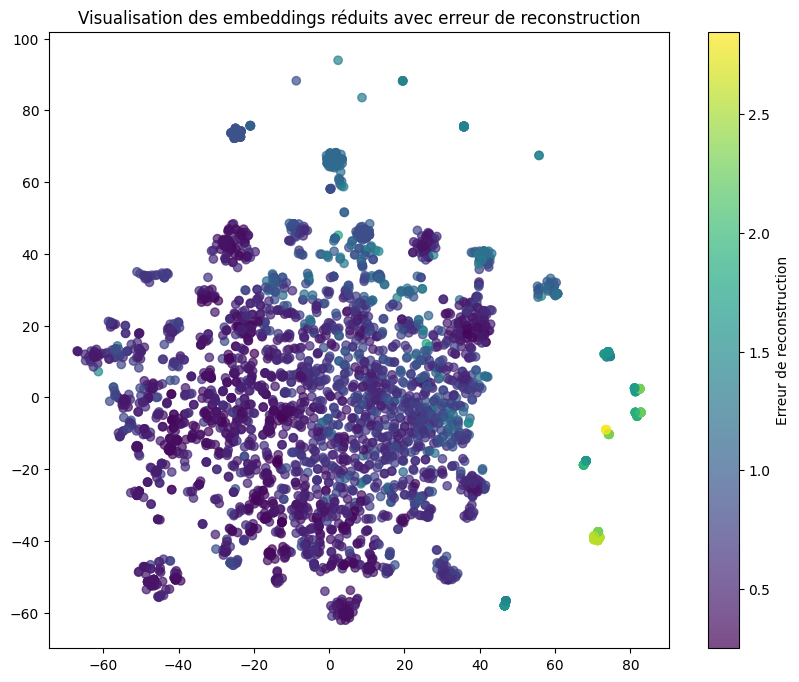

In [68]:
#cette partie permet juste de voir à quoi ressemble les ambedings après reduction de dimension et voir egalement
#les erreurs de reconstruction pour identifier les anomalies
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduire à 2D pour la visualisation si encoding_dim > 2
if encoding_dim > 2:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_2d = tsne.fit_transform(reduced_embeddings)
else:
    reduced_2d = reduced_embeddings

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], 
                     c=mse, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Erreur de reconstruction')
plt.title('Visualisation des embeddings réduits avec erreur de reconstruction')
plt.savefig('embeddings_visualization.png')
plt.show()

In [69]:
contaminated_df.head()

,combined_text,reconstruction_error,is_anomaly
0,cardiac silhouette mediastinum size within nor...,0.405361,False
1,cardiomediastinal silhouette within normal lim...,0.357072,False
2,lung clear epanded heart mediastinum normal ac...,1.392912,False
3,increased_opacity within right_upper_lobe poss...,0.787034,False
4,interstitial marking diffusely prominent throu...,1.131590,False


In [70]:
contaminated_df.tail()

,combined_text,reconstruction_error,is_anomaly
3414,lung clear cardiomediastinal silhouette within...,0.450551,False
3415,sternotomy suture bypass graft placed interval...,1.275905,False
3416,calcified mediastinal focal area consolidation...,0.484435,False
3417,"Temperature of 42°C, despite being on antipyre...",2.567127,True
3418,lung clear bilaterally focal consolidation ple...,0.326327,False


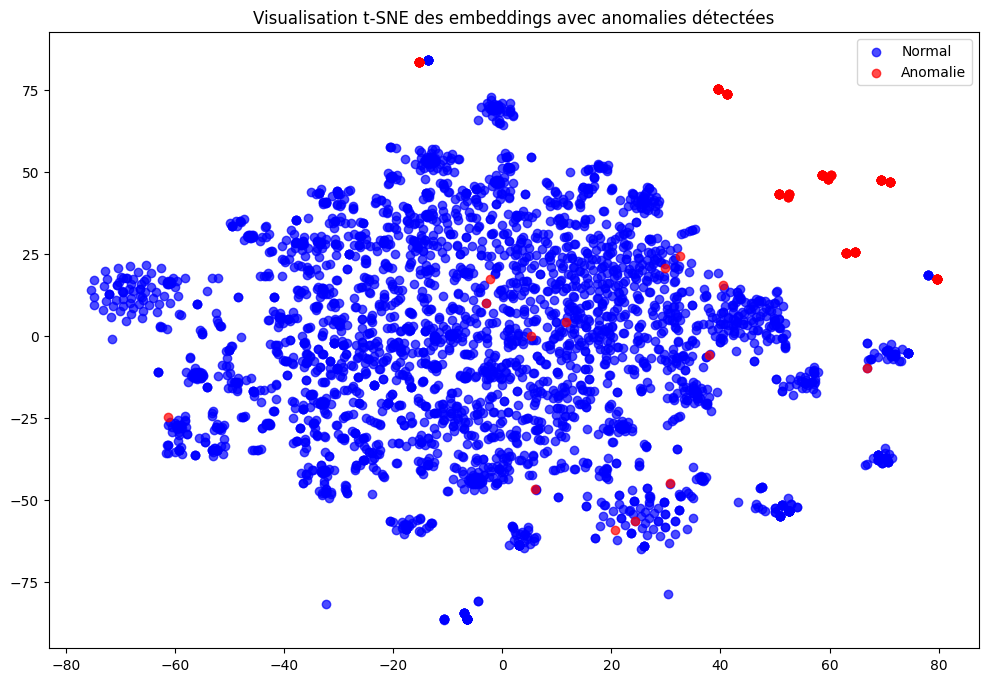

In [78]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(scaled_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[contaminated_df['is_anomaly'] == False, 0], 
            embedding_2d[contaminated_df['is_anomaly'] == False, 1], 
            c='blue', alpha=0.7, label='Normal')

plt.scatter(embedding_2d[contaminated_df['is_anomaly'] == True, 0], 
            embedding_2d[contaminated_df['is_anomaly'] == True, 1], 
            c='red', alpha=0.7, label='Anomalie')

plt.title('Visualisation t-SNE des embeddings avec anomalies détectées')
plt.legend()
plt.show()


In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X = reduced_embeddings
kmeans = KMeans(n_clusters=2, random_state=42)  # Deux clusters : anomalies vs normales
labels = kmeans.fit_predict(X)

# Calculer le coefficient de silhouette
silhouette = silhouette_score(X,labels)
db_score = davies_bouldin_score(X,labels)
ch_score = calinski_harabasz_score(X,labels)

print("\n=== Évaluation par clustering K-means ===")
print(f"Score de silhouette: {silhouette:.4f} (plus proche de 1 est meilleur)")
print(f"Score de Davies-Bouldin: {db_score:.4f} (plus bas est meilleur)")
print(f"Score de Calinski-Harabasz: {ch_score:.4f} (plus élevé est meilleur)")




=== Évaluation par clustering K-means ===
Score de silhouette: 0.2966 (plus proche de 1 est meilleur)
Score de Davies-Bouldin: 2.2484 (plus bas est meilleur)
Score de Calinski-Harabasz: 480.9059 (plus élevé est meilleur)


In [83]:
# Tester la stabilité du modèle en variant les hyperparamètres
encoding_dims = [16, 32, 64]
thresholds = [90, 95, 99]  # Percentiles

stability_results = []

for dim in encoding_dims:
    input_layer = keras.Input(shape=(input_dim,))
    encoder = keras.layers.Dense(dim*2, activation='relu')(input_layer)
    encoder = keras.layers.Dense(dim, activation='relu')(encoder)
    decoder = keras.layers.Dense(dim*2, activation='relu')(encoder)
    decoder = keras.layers.Dense(input_dim, activation='sigmoid')(decoder)
    
    model = keras.Model(input_layer, decoder)
    model.compile(optimizer='adam', loss='mse')
    
    # Entraînement rapide
    model.fit(X_train, X_train, epochs=20, batch_size=32, verbose=0)
    
    # Calculer les erreurs
    reconstructed = model.predict(scaled_embeddings)
    test_mse = np.mean(np.power(scaled_embeddings - reconstructed, 2), axis=1)
    
    for p in thresholds:
        threshold = np.percentile(test_mse, p)
        anomalies = test_mse > threshold
        num_anomalies = sum(anomalies)
        
        stability_results.append({
            'Dimension': dim,
            'Percentile': p,
            'Threshold': threshold,
            'total_anomalies': num_anomalies,
            'erreur': num_anomalies / len(test_mse)
        })

stability_df = pd.DataFrame(stability_results)
print("\n=== Analyse de stabilité ===")
print(stability_df)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step

=== Analyse de stabilité ===
   Dimension  Percentile  Threshold  total_anomalies    erreur
0         16          90   1.212376              342  0.100029
1         16          95   1.586426              168  0.049137
2         16          99   2.416679               31  0.009067
3         32          90   1.169314              324  0.094765
4         32          95   1.484877              166  0.048552
5         32          99   2.379380               31  0.009067
6         64          90   1.150056              293  0.085698
7         64          95   1.442625              171  0.050015
8         64          99   2.307793               31  0.009067
